<a href="https://colab.research.google.com/github/abdulwaheedTMU/Project2/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Data Processing

In [18]:

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define input image shape and batch size
IMG_HEIGHT, IMG_WIDTH = 500, 500
BATCH_SIZE = 32

# Set up directories
train_dir = '/content/drive/MyDrive/Project2/Data/train'
validation_dir = '/content/drive/MyDrive/Project2/Data/valid'
test_dir = '/content/drive/MyDrive/Project2/Data/test'

# Define augmentation pipeline for training data
train_data_gen = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.RandomRotation(0.2),  # Randomly rotate images
    tf.keras.layers.RandomZoom(0.3),  # More aggressive zoom
    tf.keras.layers.RandomFlip("horizontal_and_vertical"),  # Random flipping
    tf.keras.layers.RandomContrast(0.2)  # Adjust contrast
])

# Rescaling only for validation and test data
val_test_data_gen = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

# Create training dataset
train_dataset = image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="categorical",  # Multi-class classification
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
).map(lambda x, y: (train_data_gen(x, training=True), y))  # Apply augmentation pipeline

# Create validation dataset
validation_dataset = image_dataset_from_directory(
    validation_dir,
    labels="inferred",
    label_mode="categorical",
    batch_size=BATCH_SIZE,
    image_size=(IMG_HEIGHT, IMG_WIDTH)
).map(lambda x, y: (val_test_data_gen(x, training=False), y))  # Apply rescaling



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 1942 files belonging to 3 classes.
Found 431 files belonging to 3 classes.


Step 2: Neural Network Architecture Design

In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the model
model = models.Sequential()

# 1. Convolutional Layer + Max Pooling Layer
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(500, 500, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 2. Add a second Convolutional Layer + Max Pooling Layer
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 3. Add a third Convolutional Layer + Max Pooling Layer
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# 4. Flatten the output
model.add(layers.Flatten())

# 5. Fully Connected (Dense) Layer with Dropout
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.3))

# 6. Output Layer
model.add(layers.Dense(3, activation='softmax'))  # 3 neurons for 3 classes

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Display the model summary
model.summary()


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_21 (Conv2D)                   │ (None, 498, 498, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_21 (MaxPooling2D)      │ (None, 249, 249, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 247, 247, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_22 (MaxPooling2D)      │ (None, 123, 123, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 121, 121, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_23 (MaxPooling2D)      │ (None, 60, 60, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_7 (Flatten)                  │ (None, 460800)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │      29,491,264 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 29,584,707 (112.86 MB)

 Trainable params: 29,584,707 (112.86 MB)

 Non-trainable params: 0 (0.00 B)

Step 3: Hyperparameter Analysis

In [20]:
from tensorflow.keras import layers, models, optimizers

# Define model with tunable hyperparameters
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation=None, input_shape=(500, 500, 3)),  # No activation here
    layers.LeakyReLU(alpha=0.1),  # LeakyReLU activation
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),  # Standard ReLU for comparison
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation='elu'),  # ELU for dense layer
    layers.Dropout(0.6),
    layers.Dense(3, activation='softmax')  # Softmax for final layer
])

# Compile with a different optimizer (e.g., RMSprop)
model.compile(optimizer=optimizers.RMSprop(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
history = model.fit(train_dataset, validation_data=validation_dataset, epochs=20, callbacks=[early_stopping])



Epoch 1/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.3801 - loss: 3.6825 - val_accuracy: 0.5128 - val_loss: 1.0323
Epoch 2/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 169s 3s/step - accuracy: 0.5166 - loss: 1.0002 - val_accuracy: 0.5963 - val_loss: 0.9572
Epoch 3/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 168s 3s/step - accuracy: 0.5976 - loss: 0.9045 - val_accuracy: 0.5615 - val_loss: 0.8684
Epoch 4/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step - accuracy: 0.6304 - loss: 0.8309 - val_accuracy: 0.6868 - val_loss: 0.7158
Epoch 5/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 191s 3s/step - accuracy: 0.6709 - loss: 0.7792 - val_accuracy: 0.6659 - val_loss: 0.7532
Epoch 6/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 159s 3s/step - accuracy: 0.6591 - loss: 0.7533 - val_accuracy: 0.6056 - val_loss: 0.7385
Epoch 7/20
61/61 ━━━━━━━━━━━━━━━━━━━━ 160s 3s/step - accuracy: 0.6724 - loss: 0.7213 - val_accuracy: 0.5638 - val_loss: 0.9408


Step 4: Model Evaluation

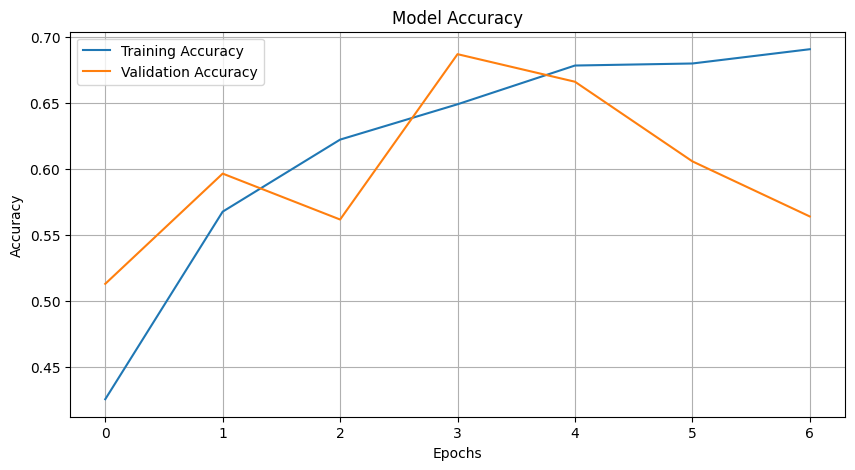

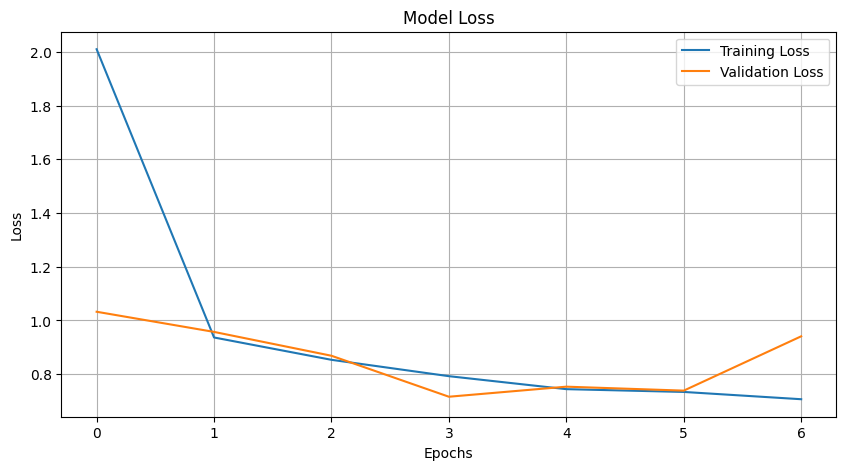

In [21]:
import matplotlib.pyplot as plt

# Plot Training and Validation Accuracy
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

# Plot Training and Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()
